# Implementing a simple convolution network for
# black/white image classification

Define global constants

In [20]:
BASE_PATH = !pwd
TF_MODEL_PATH = BASE_PATH[0] + '/tensorflow/'
TRAIN_DATA_PATH = BASE_PATH[0] + '/train_data/'
WEIGHTS_PATH = BASE_PATH[0] + '/model_weights.h5'
CLASSES_PATH = BASE_PATH[0] + '/classes_def.json'
CHECKPOINT_PATH = BASE_PATH[0] + '/weights-{epoch:02d}-{loss:.4f}.h5'
FULL_MODEL_PATH = BASE_PATH[0] + '/full_model.h5'
LOG_DIR = BASE_PATH[0] + '/logs/'

Utility functions to gather training data

In [21]:
import cv2
import numpy as np
from os import path, listdir
from keras.utils import to_categorical
from matplotlib import pyplot as plt
from tqdm import tqdm
import sys

MAX_CONTOURS = 30
IMAGE_SIZE = (1600, 900)
EPSILON_RATIO = 0.03

# Define the card size - also input of the NN model
TARGET_SIZE = (224, 224)

class ImageFile:
    def __init__(self, file_name):
        self.file_name = file_name
        self.file_data = cv2.imread(file_name)
        
        if (self.file_data.shape[0] > self.file_data.shape[1]):
            self.file_data = cv2.resize(self.file_data, (IMAGE_SIZE[1], IMAGE_SIZE[0]))
        else:
            self.file_data = cv2.resize(self.file_data, (IMAGE_SIZE[0], IMAGE_SIZE[1]))
        
        self.file_data = cv2.cvtColor(self.file_data, cv2.COLOR_BGR2RGB)
        self.grayscale_file = cv2.cvtColor(self.file_data, cv2.COLOR_BGR2GRAY)
        
    def preprocess(self):
        output = self.grayscale_file
        output = cv2.bilateralFilter(output,9,75,75)
        output = cv2.adaptiveThreshold(output,
            255, cv2.ADAPTIVE_THRESH_GAUSSIAN_C, cv2.THRESH_BINARY, 11, 2)
        output = cv2.Laplacian(output, cv2.CV_64F)
        output = np.absolute(output)
        output = np.uint8(output)

        return output

    def find_cards(self, preprocessed_img):
        dummy, contours, hierachy = cv2.findContours(preprocessed_img, 
            cv2.RETR_TREE, 
            cv2.CHAIN_APPROX_SIMPLE)
        contour_areas = [cv2.contourArea(cnt) for cnt in contours]
        
        index_sort = sorted(range(len(contours)), 
            key=lambda idx : contour_areas[idx], 
            reverse=True)
        
        if MAX_CONTOURS is not None and len(index_sort) > MAX_CONTOURS:
            index_sort = index_sort[:MAX_CONTOURS]
            
        for idx in index_sort:
            peri = cv2.arcLength(contours[idx], True)
            approx = cv2.approxPolyDP(contours[idx], EPSILON_RATIO * peri, True)
            
            if len(approx) == 4 and hierachy[0][idx][3] == -1:
                yield approx
    
    def get_card_data(self, contour):
        x, y, width, height = cv2.boundingRect(contour)
        
        points = contour.reshape(4, 2)
        
        sum_pts = np.sum(points, axis=1)
        tl = points[np.argmin(sum_pts)]
        br = points[np.argmax(sum_pts)]

        diff_pts = np.diff(points, axis=1)
        tr = points[np.argmin(diff_pts)]
        bl = points[np.argmax(diff_pts)]
        
        widthA = np.sqrt(((br[0] - bl[0]) ** 2) + ((br[1] - bl[1]) ** 2))
        widthB = np.sqrt(((tr[0] - tl[0]) ** 2) + ((tr[1] - tl[1]) ** 2))

        heightA = np.sqrt(((tr[0] - br[0]) ** 2) + ((tr[1] - br[1]) ** 2))
        heightB = np.sqrt(((tl[0] - bl[0]) ** 2) + ((tl[1] - bl[1]) ** 2))
        
        maxWidth = int(max(widthA, widthB))
        maxHeight = int(max(heightA, heightB))
        
        destination = np.array([
                [0, 0],
                [maxWidth - 1, 0],
                [maxWidth - 1, maxHeight - 1],
                [0, maxHeight - 1]
            ], dtype = 'float32')
        
        rect = np.zeros((4, 2), dtype = "float32")
        rect[0] = tl
        rect[1] = tr
        rect[2] = br
        rect[3] = bl
        
        perspective_transform = cv2.getPerspectiveTransform(rect, destination)
        
        warped_img = cv2.warpPerspective(self.grayscale_file, perspective_transform, (maxWidth, maxHeight))
        
        # Equalize histogram - https://docs.opencv.org/3.1.0/d5/daf/tutorial_py_histogram_equalization.html
#         warped_img = cv2.equalizeHist(warped_img)
        thres_level, warped_img = cv2.threshold(warped_img,
            0, 255, cv2.THRESH_BINARY + cv2.THRESH_OTSU)
        
        if maxWidth > 1.1 * maxHeight:
            warped_img = self.rotate_image(warped_img, 90)
        
        return {
            'x': x,
            'y': y,
            'img': warped_img
        }
    
    def rotate_image(self, img_data, angle):
        rows, cols, channels = img_data.shape
        (cX, cY) = (cols // 2, rows // 2)
        
        rotation_matrix = cv2.getRotationMatrix2D((cX, cY), angle, 1)
        
        cos = np.abs(rotation_matrix[0, 0])
        sin = np.abs(rotation_matrix[0, 1])
        nW = int((rows * sin) + (cols * cos))
        nH = int((rows * cos) + (cols * sin))
        rotation_matrix[0, 2] += (nW / 2) - cX
        rotation_matrix[1, 2] += (nH / 2) - cY
        
        return cv2.warpAffine(img_data, rotation_matrix, (nW, nH))
    
    def extract_cards(self, resize=None):
        img_data = self.preprocess()
        contours = self.find_cards(img_data)
        
        for contour in contours:
            data = self.get_card_data(contour)
            if resize is not None:
                data['img'] = cv2.resize(data['img'], resize)
            yield data

def plot_image(img_data):
    plt.imshow(img_data)
    plt.axis('off')  # to hide the axes
    plt.show()
    
def get_training_files():
    labels = []
    images = []
    
    for label_dir in [item for item in listdir(TRAIN_DATA_PATH) if path.isdir(TRAIN_DATA_PATH + item)]:
        full_dir = TRAIN_DATA_PATH + label_dir + '/'
        for train_file in [item for item in listdir(full_dir) if path.isfile(full_dir + item)]:
            images.append(full_dir + train_file)
            labels.append(label_dir)

    classes = list(set(labels))
    print('number of classes %s, number of files %s' % (len(classes), len(images)))
    
    return {
        'labels': labels,
        'images': images,
        'classes': classes
    }

def get_training_data(data = None):
    if data is None:
        data = get_training_files()
    
    labels = data['labels']
    images = data['images']
    classes = data['classes']
    
    num_classes = len(classes)
    
    for idx, image in enumerate(images):
        # take the first card found
        image_file = next(ImageFile(image) \
            .extract_cards(resize=TARGET_SIZE), None)
        if image_file is not None:
            image_file = np.array(image_file['img'], dtype='float32')
            label = to_categorical(classes.index(labels[idx]), num_classes=num_classes)
            yield (image_file, label)
        else:
            print('Warning: Card not found in file %s' % image)

Testing the data extraction function:

number of classes 4, number of files 20


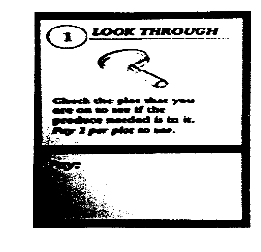

[1. 0. 0. 0.]


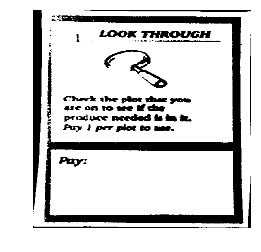

[1. 0. 0. 0.]


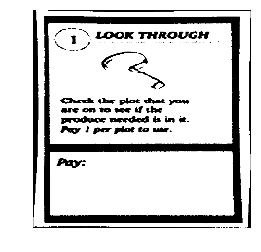

[1. 0. 0. 0.]


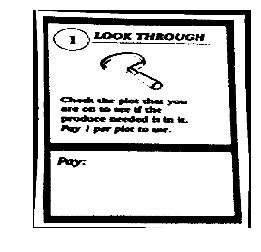

[1. 0. 0. 0.]


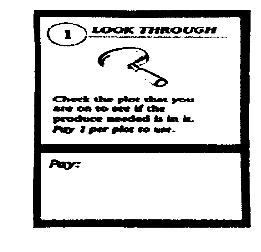

[1. 0. 0. 0.]


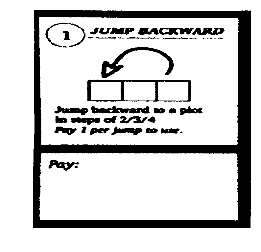

[0. 0. 0. 1.]


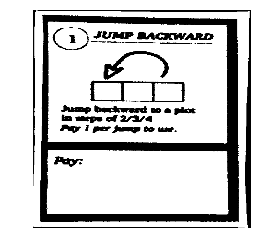

[0. 0. 0. 1.]


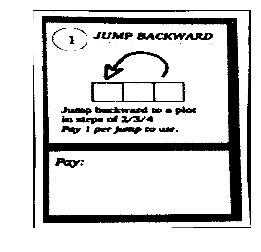

[0. 0. 0. 1.]


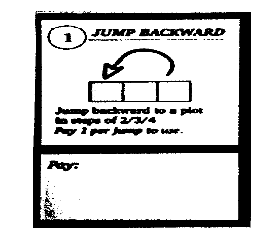

[0. 0. 0. 1.]


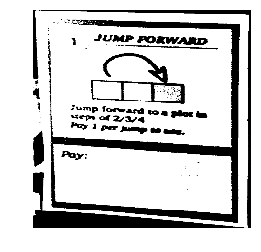

[0. 1. 0. 0.]


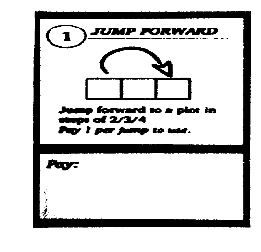

[0. 1. 0. 0.]


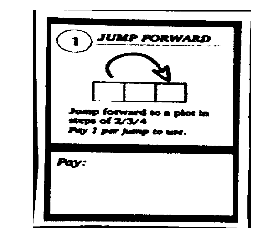

[0. 1. 0. 0.]


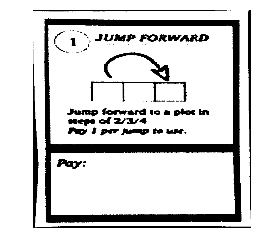

[0. 1. 0. 0.]


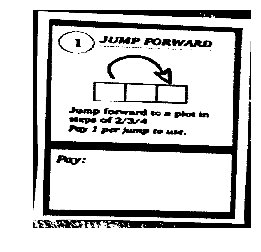

[0. 1. 0. 0.]


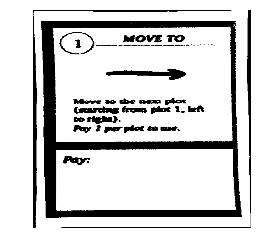

[0. 0. 1. 0.]


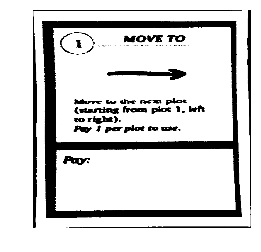

[0. 0. 1. 0.]


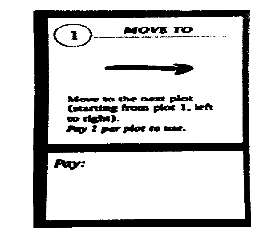

[0. 0. 1. 0.]


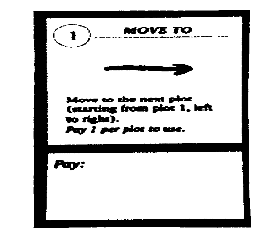

[0. 0. 1. 0.]


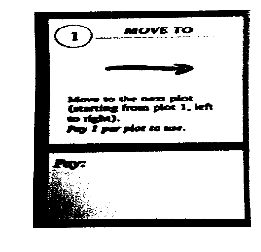

[0. 0. 1. 0.]


In [22]:
files = get_training_files()
training_data = list(get_training_data(data=files))
for image, label in training_data:
    image = np.stack((image,)*3, axis=-1).astype('uint8')
    plot_image(image)
    print(label)

Black/White only image classification model

In [23]:
from keras.models import Sequential
from keras.layers import Dense, Dropout, Convolution2D, SeparableConvolution2D, BatchNormalization, Activation, MaxPooling2D, GlobalAveragePooling2D
from keras import backend as K

def SimpleConvNet(weights_path=None,
                  classes=10):
    input_shape = (TARGET_SIZE[0], TARGET_SIZE[1], 1)
    model = Sequential()
    model.add(Convolution2D(32, kernel_size=(3, 3), padding='same', input_shape=input_shape))
    model.add(BatchNormalization())
    model.add(Activation('elu'))
    model.add(MaxPooling2D(pool_size=(2,2)))
    
    model.add(SeparableConvolution2D(64, (3, 3), padding='same'))
    model.add(BatchNormalization())
    model.add(Activation('elu'))
    model.add(MaxPooling2D(pool_size=(2,2)))
    
    model.add(SeparableConvolution2D(128, (3, 3), padding='same'))
    model.add(BatchNormalization())
    model.add(Activation('elu'))
    
    model.add(SeparableConvolution2D(128, (3, 3), padding='same'))
    model.add(BatchNormalization())
    model.add(Activation('elu'))
    
    model.add(SeparableConvolution2D(256, (3, 3), padding='same'))
    model.add(BatchNormalization())
    model.add(Activation('elu'))
    
    model.add(SeparableConvolution2D(256, (3, 3), padding='same'))
    model.add(BatchNormalization())
    model.add(Activation('elu'))
    
    model.add(GlobalAveragePooling2D())
    model.add(Dropout(0.25))
    model.add(Dense(classes, activation='softmax'))
    
    if weights_path is not None:
        try:
            model.load_weights(weights_path)
        except:
            print('Error loading model weights. Starting from scratch')
            pass
        
    return model

Testing the model construct

In [24]:
model = SimpleConvNet()
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_8 (Conv2D)            (None, 224, 224, 32)      320       
_________________________________________________________________
batch_normalization_23 (Batc (None, 224, 224, 32)      128       
_________________________________________________________________
activation_23 (Activation)   (None, 224, 224, 32)      0         
_________________________________________________________________
max_pooling2d_16 (MaxPooling (None, 112, 112, 32)      0         
_________________________________________________________________
separable_conv2d_16 (Separab (None, 112, 112, 64)      2400      
_________________________________________________________________
batch_normalization_24 (Batc (None, 112, 112, 64)      256       
_________________________________________________________________
activation_24 (Activation)   (None, 112, 112, 64)      0         
__________

Training the model

In [25]:
from keras_tqdm import TQDMNotebookCallback
from keras.callbacks import TensorBoard, ModelCheckpoint, EarlyStopping
from keras.preprocessing.image import ImageDataGenerator

def load_model(weights_path=None, classes=1000):
    return SimpleConvNet(weights_path=weights_path, classes=classes)

def train_model(X_train=None,
                Y_train=None,
                X_test=None,
                Y_test=None,
                epochs=30,
                classes=1000,
                weights_path=None):
    if weights_path is None:
        weights_path = WEIGHTS_PATH

    print('Final model will be saved to: %s' % weights_path)
    
    if path.isfile(weights_path):
        model = load_model(weights_path=weights_path, classes=classes)
    else:
        model = load_model(weights_path=None, classes=classes)
    
    model.compile(optimizer='rmsprop', 
        loss='categorical_crossentropy',
        metrics=['accuracy'])
    
    batch_size = 32
    
    # Workaround for a tqdm issue
    # https://github.com/tqdm/tqdm/issues/481
    tqdm.monitor_interval = 0
    callbacks = [
        TensorBoard(log_dir=LOG_DIR,
            write_graph=True,
            write_images=True, 
            write_grads=True,
            batch_size=batch_size),
        ModelCheckpoint(CHECKPOINT_PATH, 
            monitor='loss', 
            verbose=1, 
            save_best_only=True, 
            mode='min',
            period=2),
        EarlyStopping(monitor='loss', 
            min_delta=0.0001, 
            patience=5, 
            verbose=1, 
            mode='auto'),
        TQDMNotebookCallback()
    ]
    
    if X_test is not None and Y_test is not None:
        validation_data = (X_test, Y_test)
    else:
        validation_data = None
        
    datagen = ImageDataGenerator(
        rotation_range=20,
        width_shift_range=0.1,
        height_shift_range=0.1,
        shear_range=0.1,
        zoom_range=0.1,
        fill_mode='constant')
    
    datagen.fit(X_train)
    
    try:
        model.fit_generator(
            datagen.flow(X_train, Y_train, batch_size=batch_size),
            validation_data=validation_data,
            steps_per_epoch=1000,
            epochs=epochs,
            callbacks=callbacks,
            verbose=0)
#         model.fit(X_train, Y_train, 
#                   batch_size=16, 
#                   epochs=1000, 
#                   callbacks=callbacks, 
#                   verbose=0)
        model.save_weights(weights_path)

    except KeyboardInterrupt:
        model.save_weights(weights_path)

    return model

Exporting the model to Tensorflow protobuf format

In [26]:
from tensorflow.python.framework import graph_util, graph_io
import tensorflow as tf

def export_model(model, 
                 output_folder=None,
                 graphdef_file='graphdef.txt',
                 model_file='model.pb',
                 output_node_prefix='reshape_2'):
    K.set_learning_phase(0)
    sess = K.get_session()
    
    num_outputs = len(model.outputs)
    
    pred = [None]*num_outputs
    pred_node_names = [None]*num_outputs
    for i in range(num_outputs):
        pred_node_names[i] = output_node_prefix+str(i)
        pred[i] = tf.identity(model.outputs[i], name=pred_node_names[i])
    print('output nodes names: ', pred_node_names)
    
    graph = sess.graph
    graph_def = graph.as_graph_def()
    
    # Output the graph definition in ASCII
    tf.train.write_graph(graph_def, output_folder, graphdef_file, as_text=True)
    
    # Convert variables to constants
    constant_graph = graph_util.convert_variables_to_constants(sess, graph_def, pred_node_names)
    graph_io.write_graph(constant_graph, output_folder, model_file, as_text=False)

# Test training the model
Putting it all together

(224, 224, 3)


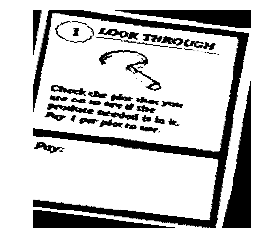

[1. 0. 0. 0.]
(224, 224, 3)


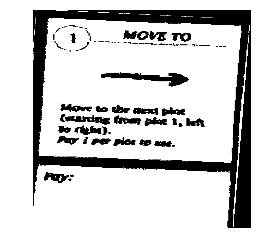

[0. 0. 1. 0.]
(224, 224, 3)


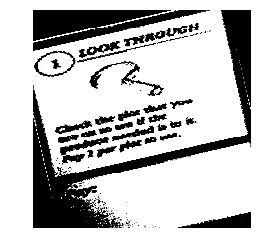

[1. 0. 0. 0.]
(224, 224, 3)


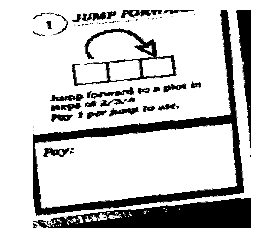

[0. 1. 0. 0.]
(224, 224, 3)


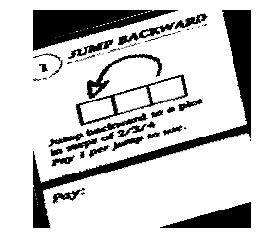

[0. 0. 0. 1.]
(224, 224, 3)


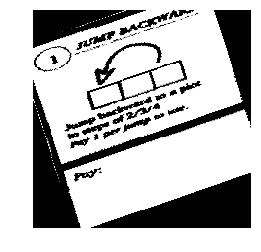

[0. 0. 0. 1.]
(224, 224, 3)


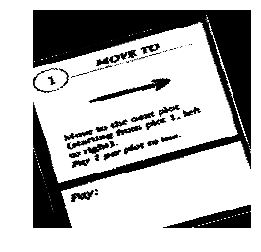

[0. 0. 1. 0.]
(224, 224, 3)


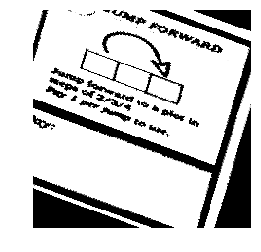

[0. 1. 0. 0.]
(224, 224, 3)


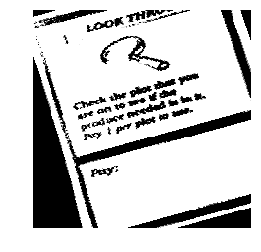

[1. 0. 0. 0.]
(224, 224, 3)


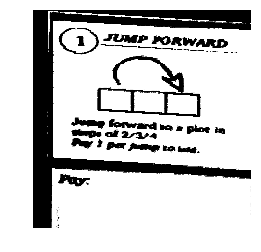

[0. 1. 0. 0.]
(224, 224, 3)


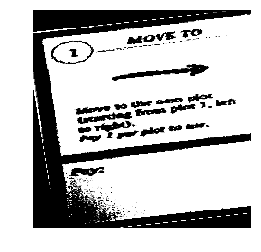

[0. 0. 1. 0.]
(224, 224, 3)


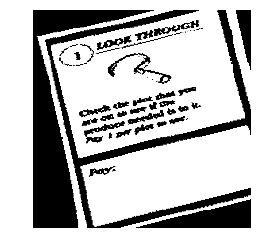

[1. 0. 0. 0.]
(224, 224, 3)


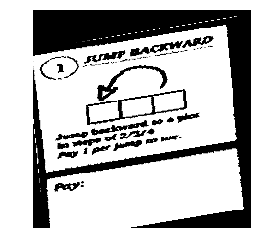

[0. 0. 0. 1.]
(224, 224, 3)


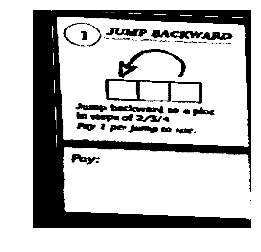

[0. 0. 0. 1.]
(224, 224, 3)


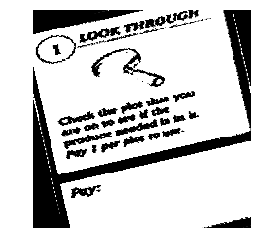

[1. 0. 0. 0.]
(224, 224, 3)


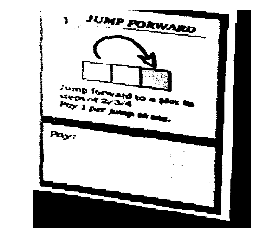

[0. 1. 0. 0.]
(224, 224, 3)


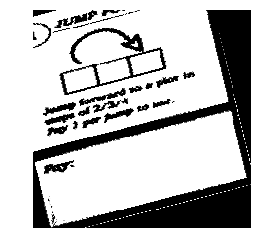

[0. 1. 0. 0.]
(224, 224, 3)


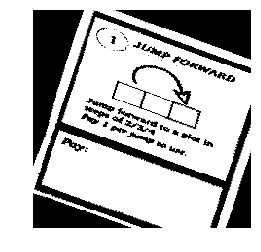

[0. 1. 0. 0.]
(224, 224, 3)


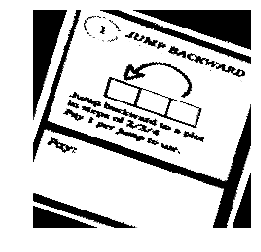

[0. 0. 0. 1.]
(224, 224, 3)


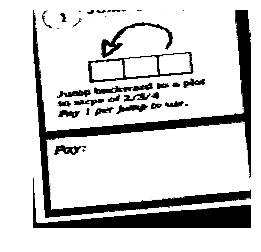

[0. 0. 0. 1.]


In [ ]:
X_train = []
Y_train = []
num_classes = len(files['classes'])
for image, label in training_data:
    X_train.append(image[:, :, np.newaxis])
    Y_train.append(label)
X_train = np.array(X_train, dtype='float32')
Y_train = np.array(Y_train, dtype='float32')

# Test the image generator
datagen = ImageDataGenerator(
    rotation_range=20,
    width_shift_range=0.1,
    height_shift_range=0.1,
    shear_range=0.1,
    zoom_range=0.1,
    fill_mode='constant')

datagen.fit(X_train)

for _ in range(20):
    X_data, Y_data = next(datagen.flow(X_train, Y_train, batch_size=1))
    image = np.repeat(X_data[0], 3, axis=-1).astype('uint8')
    print(image.shape)
    plot_image(image)
    print(Y_data[0])

In [ ]:
train_model(X_train, Y_train, classes=num_classes)

Final model will be saved to: /Users/2359media/Documents/card-extractor/model_weights.h5
Error loading model weights. Starting from scratch


HBox(children=(IntProgress(value=0, description='Training', max=30), HTML(value='')))

HBox(children=(IntProgress(value=0, description='Epoch 0', max=1000), HTML(value='')))

In [ ]:
import json

with open(CLASSES_PATH, 'w') as classes_file:
    json.dump(files['classes'], classes_file, indent=4)

model = load_model(WEIGHTS_PATH, classes=num_classes)
model.summary()

In [ ]:
model.save(FULL_MODEL_PATH)
export_model(model, output_folder=TF_MODEL_PATH)